In [290]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal

# Am Anfang wird immer in Bursts übertragen, ohne Kontinuierliches Senden

# IQ Sampling

Ziel dieses Notebooks ist es, ein Verständnis für die generierung und Abtastung von IQ-Samples zu entwickeln. Dabei soll Rauschen und der Einfluss des Kanals zunächst vernachlässigt werden. Der Fokus soll hier allein auf dem Verständnis liegen, wie IQ Samples von einem SDR versendet werden, als reales Signal übertragen werden und wie sie empfangen werden.

Am Ende des Notebooks sollte folgendes klar sein:

- Was sind IQ-Samples?
- Das Sendesignal wird immer komplex beschrieben. Übertragen wird jedoch nur der Realteil. Warum?
- Wie werden aus dem realen, analogen Empfangssignal die komplexen IQ-Samples gewonnen?
- Warum können der I- und Q-Teil überlagert ausgesendet werden und dennoch beim Empfänger getrennt werden?

## Theoretischer Background: TX und RX

### Transmitter

Der Transmitter (TX) erzeugt ein diskretes komplexes Basisband-Signal $s_{\text{NF}}[n]$, welches in der Regel als I/Q-Signal bezeichnet wird. Das I/Q-Signal besteht aus zwei Komponenten: der In-Phase-Komponente (I) und der Quadratur-Komponente (Q). Das I/Q-Signal $s_{\text{NF}}[n]$ wird dann auf eine Trägerfrequenz $f_{\text{c}}$ hochgemischt und als analoges Passband Signal $s_{\text{HF}}(t)$ übertragen.

-> hier bild einfügen


$$s_{\text{NF}}[n] = I[n] + j \text{ } Q[n]$$

* $I[n]$ ist die In-Phase-Komponente (Kosinus Anteil, Realteil)
* $Q[n]$ ist die Quadratur-Komponente (Sinus Anteil, Imaginärteil)
* Bsp.: QPSK-Sample
$$
\begin{align*}
s_{\text{QPSK}} &= 1 + j \\
                &= \sqrt{2} \text{ } e^{j\frac{\pi}{4}} \\
                &=  \sqrt{2} \cos(\frac{\pi}{4}) + j \sqrt{2}  \sin(\frac{\pi}{4}) \\
                &= I + j Q
                &= \sqrt{2} \left(\frac{\sqrt{2}}{2} + j \frac{\sqrt{2}}{2}\right) \\
                &= 1 + j
\end{align*}
$$
  * Der Imaginärteil ist also der Sinus-Anteil, der Realteil der Kosinus-Anteil

![IQ Sampling Receiver](./images/IQ_diagram_sender.png)

Werden die IQ-Samples vom ausgesendet, werden sie als reales Signal übertragen.

$$
                        s(t) = I(t) + j \text{ } Q(t) \text{ } e^{j 2 \pi f_{\text{c}} t} = I(t) \cos(2 \pi f_{\text{c}} t) - Q(t) \sin(2 \pi f_{\text{c}} t)
$$

Im SDR wird das wie im Blockschaltbild folgendermaßen realisiert:
Es wird ein Sinus generiert, welcher auf die Trägerfrequenz $f_{\text{c}}$ gemischt wird. Dieser wird dann zum einen mit der Imaginären Komponente (Q-Komponente) multipliziert. Und zum anderen wird auf ihn eine Phaseshift von 90° angewendet, das Vorzeichen umgekehrt und mit der realen Komponente (I-Komponente) multipliziert. Die beiden Signale werden dann addiert und ergeben das Sendesignal.

Bemerkung Orthogonalität: Die beiden Signale sind orthogonal zueinander, d.h. das Skalarprodukt ist 0. Das bedeutet, dass die beiden Signale unabhängig voneinander sind und der Empfänger die I und Q Komponenten aus der Summe extrahieren kann.
$$
    s_{\text{HF}}(t) = I(t) \cos(2 \pi f_{\text{c}} t) + Q(t) \sin(2 \pi f_{\text{c}} t)
$$

In [291]:
def generate_m_sequence_16bit():
    """
    Generiert eine 16 Bit lange M-Sequenz mit LFSR (Linear Feedback Shift Register)
    Verwendetes primitives Polynom: x^4 + x^3 + 1 (Taps an Position 3 und 4)
    """
    register = [1, 1, 1, 1]  # Initialzustand (darf nicht alle 0 sein)
    sequence = []

    for _ in range(16):
        # Feedback-Berechnung (XOR der Taps)
        feedback = register[3] ^ register[2]  # 0-indizierte Positionen
        sequence.append(register.pop())
        register.insert(0, feedback)

    return sequence


def normalize_energy(signal):
    energy = np.sum(np.abs(signal) ** 2)
    return signal / np.sqrt(energy)


## Generierung des Sendesignals

Das Sendesignal wird aus den Datenbits und einer Synchronisationssequenz generiert. Die Synchronisationssequenz wird verwendet, um den Empfänger zu synchronisieren. Das Sendesignal wird dann mit einem Raised-Cosine Filter gepulst, um die Bandbreite des Signals zu begrenzen.

### Konvertierung der Datenbits $\vec{b}[i]$ in BPSK Samples

   $$
    \text{BPSK}(i) = \vec{b}[i] \cdot 2 - 1
   $$

Es sollen T = 8 Samples pro Symbol verwendet werden. Das Sendesignal wird dann wie folgt generiert:

$$
    x_{\text{NF, no shape}}[n] = \sum_{i=0}^{N-1} \text{BPSK}(i) \delta\left(n - i T\right)
$$

Für IQ-Modulation wird das für den I und Q Teil getrennt durchgeführt, somit ergibt sich:

$$
    x_{\text{I, no shape}}[n] = \Re\left\{x_{\text{NF, no shape}}[n]\right\}
$$
$$
    x_{\text{Q, no shape}}[n] = \Im\left\{x_{\text{NF, no shape}}[n]\right\}
$$

Im Falle von BPSK bleibt der Imaginärteil immer 0, da die BPSK Symbole nur auf der Realachse liegen, sodass hier nur $x_{\text{I, no shape}}[n]$ betrachtet wird.

In [292]:
def get_raised_cosine_pulse(num_taps=101, roll_off=0.35, samples_per_symbol=8):
    Ts = samples_per_symbol # Assume sample rate is 1 Hz, so sample period is 1, so *symbol* period is 8
    t = np.arange(num_taps) - (num_taps-1)//2
    h = np.sinc(t/Ts) * np.cos(np.pi*roll_off*t/Ts) / (1 - (2*roll_off*t/Ts)**2)
    return h

def get_rect_pulse(num_taps=101, samples_per_symbol=8):
    h = np.zeros(num_taps)
    h[num_taps//2-samples_per_symbol//2:num_taps//2+samples_per_symbol//2] = 1
    return h

## Generierung der Bits $\vec{b}[i]$

In [293]:
data_bits = np.array([0,0,1,1,1])


#sps = 8 # symboldauer hat einfluss auf die bandbreite des basisbandsignals

synchronization_sequence = generate_m_sequence_16bit()
bits = np.concatenate((synchronization_sequence, data_bits))
bits

array([1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1])

### Mapping der Bits $\vec{b}[i]$ auf BPSK Modulationssymbole

- Ziel: NumPy Array mit den Modulationssymbolen
- Jedes Bit $b[i]$ wird auf ein BPSK Modulationssymbol gemappt
- Anweisung: Überlegen Sie sich, wie Sie die Bits auf die BPSK-Modulationssymbole mappen

In [294]:
# BPSK Modulation
BPSK = 2 * bits - 1

### Design Basisbandpulse $h_{\text{Pulse Form}}[n]$

In [295]:
# basisband pulse soll eine Dauer T_s von 0.5 Sekunden haben
T_s = 1/2 # in seconds

# der pulse soll 8 samples lang sein
sps = 8

# Dauer eines Samples entspricht duration / sps
T_sample = T_s / sps

# num tabs gibt die länge des filters an, muss natürlich länger sein als die länge des pulses
num_taps = 50

# baseband pulse
h = get_rect_pulse(num_taps=num_taps, samples_per_symbol=sps)

# der Zeitvektor für das Basisbandpuls ist somit t = index * sample_duration
t = np.arange(len(h)) * T_sample - len(h)//2 * T_sample

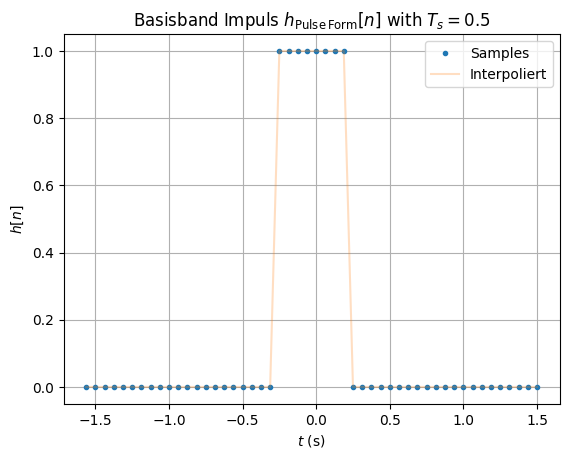

In [296]:
# plot the baseband pulse
plt.figure(1)
plt.plot(t, h, '.')
plt.plot(t, h, '-', alpha=0.25)
plt.xlabel(r'$t$ (s)')
plt.ylabel(r'$h[n]$')
plt.title(r"Basisband Impuls $h_{\mathrm{Pulse\,Form}}[n]$ with $T_s = $" + f"{T_s}")
plt.grid(True)
plt.legend(["Samples", "Interpoliert"])

### Spektrum des Basisbandimpulses $\mathfrak{F} \{ h_{\text{Pulse Form}}[n] \}$

- Hinweis: Den Frequenzvektor $f$ erhalten Sie durch die Funktion `np.fft.fftfreq(signal.length, time_between_samples)`
- NumPy bringt die Nullfrequenz an den Anfang, daher sollten Sie die Funktion `np.fft.fftshift` verwenden, um die Nullfrequenz in die Mitte zu schieben
- Denken Sie daran, das gleiche auch für den Frequenzvektor $f$ zu tun

In [297]:
baseband_spectrum = np.fft.fftshift(np.fft.fft(h))
f = np.fft.fftshift(np.fft.fftfreq(len(h), T_sample))

(0.01, 100)

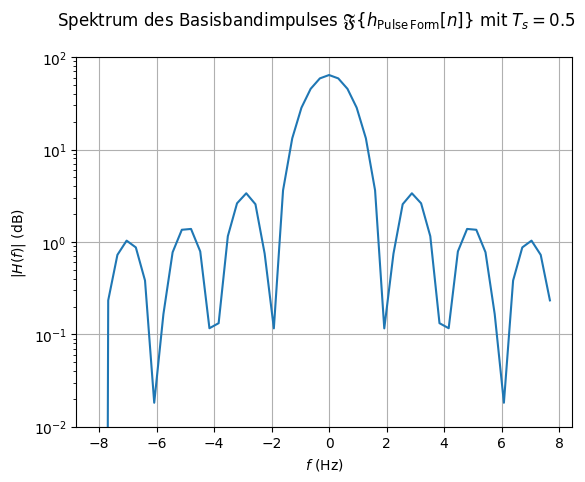

In [298]:
plt.plot(f, np.abs(baseband_spectrum)**2)
plt.suptitle(r"Spektrum des Basisbandimpulses $\mathfrak{F} \{ h_{\mathrm{Pulse\,Form}}[n] \}$ mit $T_s = $" + f"{T_s}")
plt.xlabel(r'$f$ (Hz)')
plt.ylabel(r'$|H(f)|$ (dB)')
plt.grid(True)
plt.yscale('log')
plt.ylim(10e-3, 100)

### Frage: Mit welcher Abtastrate $f_s$ müsste das Basisbandsignal abgetastet werden, um das Basisbandsignal zu rekonstruieren?

In [299]:
freq = 2 * 1/T_s
freq

4.0

### Bilden Sie die Dirac-Summe der Modulationssymbole $ \sum_{i=0}^{N-1} \text{BPSK}(i) \delta\left(t - i T_s\right) $

- Ziel: NumPy Array mit der Dirac-Summe
- Hinweis: Die Zeit $t$ ist diskret, wobei ein Indexbin $n$ einem Zeitpunkt $t = n \cdot T_{\text{Sample}}$ entspricht
    - Die Dauer eines Samples $T_{\text{sample}}$ ist gegeben durch: $T_{\text{sample}} = \frac{T_s}{\text{sps}}$
- Das bedeutet die einzelnen Dirac-Summanden brauchen einen zeitlichen Abstand von $T_{\text{s}}$,
was in Samples durch die Beziehung $T_{Sample} $  [ $ \frac{s}{Sample} $] $ =  \frac{T_s}{sps} \text{ } $[ $ \frac{s}{Sample} $] gegeben ist. Durch Umstellen ergibt sich der Abstand in Samples durch:

$$ \text{sps} = \frac{T_s}{T_{\text{Sample}}} \quad \text{, die Einheit beider Seiten ist nun Samples}$$

In Bins ausgedrückt ergibt sich die Dirac-Summe also zu:

$$
    x_{\text{I, no shape}}[n] = \sum_{i=0}^{N-1} \text{BPSK}(i) \delta\left(n - i \text{sps}\right) \quad \text{, mit } N = \text{len(BPSK)}\cdot sps
$$


In [300]:
x_i_no_shape = np.zeros(len(BPSK) * sps)
t = np.arange(len(x_i_no_shape)) * T_sample
for n in range(len(BPSK)):
    # signal.gausspulse
    x_i_no_shape += BPSK[n] * signal.gausspulse(t - n*T_s)

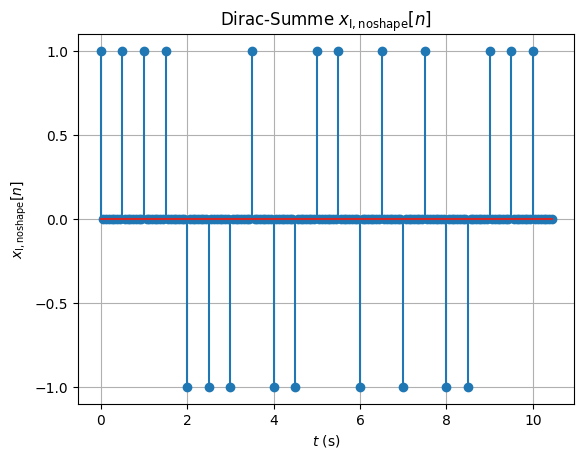

In [301]:
plt.stem(t, x_i_no_shape)
plt.grid(True)
plt.xlabel(r'$t$ (s)')
plt.ylabel(r'$x_{\rm{I, no shape}}[n]$')
plt.yticks([-1, -0.5, 0, 0.5, 1])
plt.title(r"Dirac-Summe $x_{\rm{I, no shape}}[n]$")
plt.show()

## Pulsformung

Das Sendesignal wird nun mit der Basisbandpulse $h_{\tiny{\text{Pulse Form}}}[n]$ Form geformt. Die BPSK Modulationssamples für den I-Anteil werden $x_{\text{I, no shape}}[n] = \Re\left\{x_{\text{NF, no shape}}[n]\right\}$ (Dirac-Summe) werden also mit $h_{\tiny{\text{Pulse Form}}}[n]$ gefaltet:

$$
    x_{\text{I, shaped}}[n] = x_{\text{I, no shape}}[n] * h_{\tiny{\text{Pulse Form}}}[n]
$$
Wird als Basisbandpuls ein Raised-Cosine verwendet, ergibt sich die Faltung zu:
$$
h_{\tiny{\text{Pulse Form}}}[n] = \text{sinc}\left(\frac{n}{T_s f_s}\right) \cdot \frac{\cos\left(\pi \beta \frac{n}{T_s f_s}\right)}{1 - \left(2 \beta \frac{n}{T_s f_s}\right)^2}
$$

where:
\begin{align*}
\text{sinc}(x) &= \frac{\sin(\pi x)}{\pi x} \\
T_s &= \text{symbol period} \\
\beta &= \text{roll-off factor} \\
f_s &= \text{sampling frequency}
\end{align*}

### Berechnung von $x_{\text{I, shaped}}[n]$

- Ziel: NumPy Array _x_i_shaped_ mit dem geformten Sendesignal
- Hinweise:
    - Nutzen Sie die Funktion _np.convolve_ für die Faltung
    - Der Basisbandpuls $h_{\tiny{\text{Pulse Form}}}[n]$ ist bereits gegeben: _h_

In [302]:
x_i_shaped = np.convolve(x_i_no_shape, h)

t = np.arange(x_i_shaped.size) * T_sample

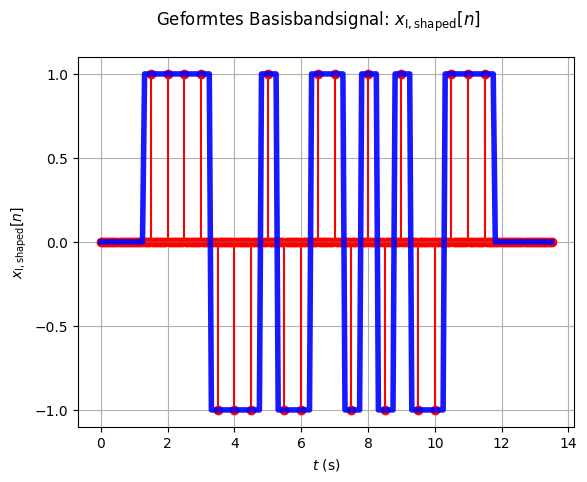

In [303]:
# convert the shape of the dirac sum to the shape of the convolution result
dirac_sum_zero_padded = np.zeros(len(x_i_shaped))
dirac_sum_zero_padded[h.size//2-1:h.size//2+len(x_i_no_shape)-1] = x_i_no_shape
plt.suptitle(r"Geformtes Basisbandsignal: $x_{\rm{I, shaped}}[n]$")
plt.stem(t, dirac_sum_zero_padded, 'r')
plt.plot(t, x_i_shaped, 'b', linewidth=4, alpha=0.9)
plt.yticks([-1, -0.5, 0, 0.5, 1])
plt.grid(True)
plt.xlabel(r'$t$ (s)')
plt.ylabel(r'$x_{\rm{I, shaped}}[n]$')
plt.show()

#### Spektrum des geformten Sendesignals $x_{\text{I, shaped}}[n]$

In [304]:
x_i_shaped_spectrum = np.fft.fftshift(np.fft.fft(x_i_shaped))
f = np.fft.fftshift(np.fft.fftfreq(x_i_shaped.size, T_sample))

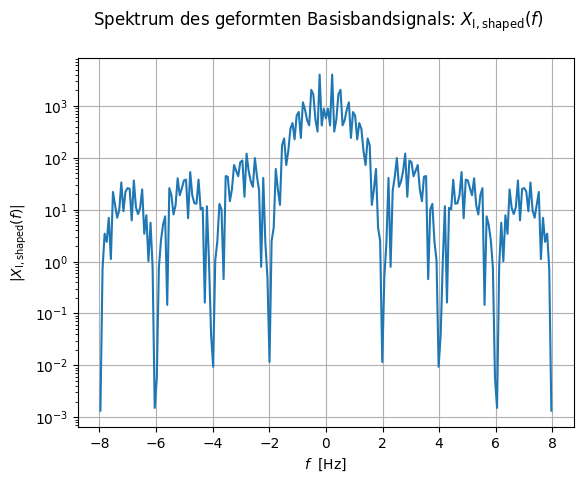

In [305]:
plt.plot(f, np.abs(x_i_shaped_spectrum)**2)
plt.suptitle(r"Spektrum des geformten Basisbandsignals: $X_{\rm{I, shaped}}(f)$")
plt.xlabel(r"$f$  [Hz]")
plt.ylabel(r"$|X_{\rm{I, shaped}}(f)|$")
plt.grid(True)
plt.yscale('log')

### Aufbau des Trägersignals

![IQ Sampling Receiver](./images/IQ_diagram_sender.png)

- Gemäß des Blockschaltbildes brauchen wir ein Carrier $s_c(t)$, welcher das Basisbandsignal auf eine Trägerfrequenz $f_c$ hochmischen kann
- Dieser wird direkt mit dem I-Anteil des Basisbandsignals $x_{\text{I, shaped}}(t)$ multipliziert
- Der I-Anteil wird laut obigen Berechnungen mit dem Cosinus übertragen. Blockschaltbild konform muss $s_c(t)$ für den I-Anteil also wie folgt aussehen:
$$
    s_{\text{c,I}}(t) = \cos(2 \pi f_c t)
$$
- Aus der $90°$ Phasendrehung folgt, dass $s_c(t)$ für den Q-Anteil wie folgt aussehen muss:
$$
    s_{\text{c,Q}}(t) = \cos(2 \pi f_c t + \frac{\pi}{2}) = \sin(2 \pi f_c t)
$$

*Aufgabe*: Generieren Sie zur gegebenen $f_c$ die Träger $s_{\text{c,I}}(t)$ und $s_{\text{c,Q}}(t)$

In [306]:
t = np.arange(x_i_shaped.size) * T_sample
f_c = 2

s_c_I = np.cos(2*np.pi*f_c*t)
s_c_Q = np.cos(2*np.pi*f_c*t - np.pi/2)

([<matplotlib.axis.YTick at 0x15a8458d0>,
 [Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0')])

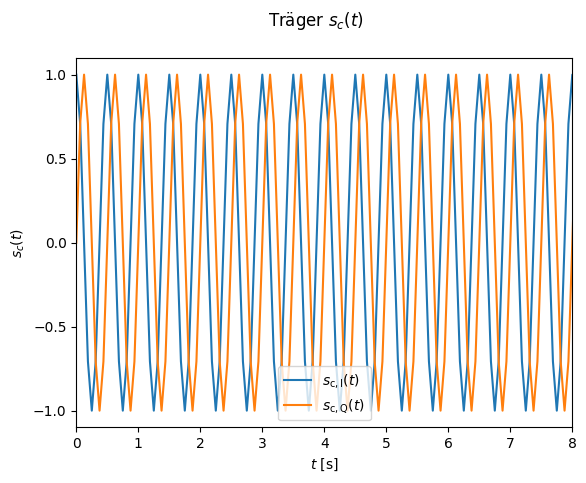

In [307]:
plt.plot(t, s_c_I)
plt.plot(t, s_c_Q)
plt.suptitle(r"Träger $s_c(t)$")
plt.xlabel(r"$t$ [s]")
plt.ylabel(r"$s_c(t)$")
plt.legend([r"$s_{\rm{c,I}}(t) $", r"$s_{\rm{c,Q}}(t) $"])
plt.xlim(0,8)
plt.yticks([-1,-0.5,0,0.5,1])

### Hoschmischen des Basisbandsignals $x_{\text{I, shaped}}(t)$ auf die Trägerfrequenz $f_c$

- Hinweis: Es wurde von Beginn an BPSK verwendet. Die Symbole haben ausschließlich einen Realteil, daher ist der Q-Anteil des Basisbandsignals  $x_{\text{Q, shaped}}(t) = 0$. Es muss demnach also nur der I-Anteil hochgemischt werden $x_{\text{I, shaped}}(t)$:

Das Passbandsignal $s_{\text{HF}}(t)$ kann also wie folgt beschrieben werden:
$$
    s_{\text{HF}}(t) = I(t) \cos(2 \pi f_{\text{c}} t) - Q(t) \sin(2 \pi f_{\text{c}} t) = x_{\text{I, shaped}}(t) \cos(2 \pi f_{\text{c}} t) - 0 \cdot \sin(2 \pi f_{\text{c}} t)
$$

In [308]:
s_hf = x_i_shaped * s_c_I - 0 * s_c_Q
t = np.arange(s_hf.size) * T_sample

Text(0.5, 0, '$t$ [s]')

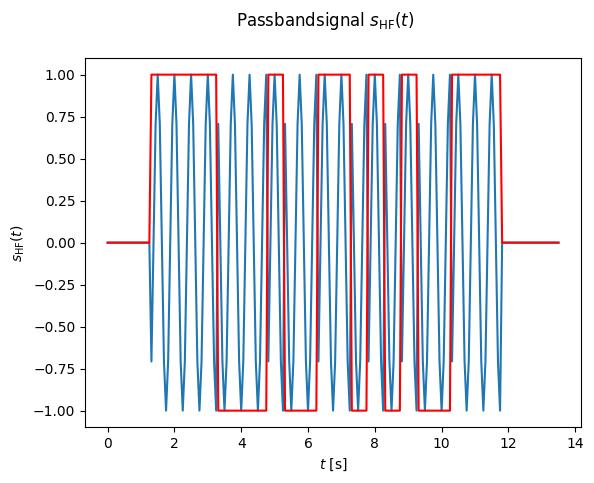

In [309]:
plt.plot(t, s_hf)
plt.plot(t, x_i_shaped, color='red')
plt.suptitle(r"Passbandsignal $s_{\rm{HF}}(t)$")
plt.ylabel(r"$s_{\rm{HF}}(t)$")
plt.xlabel(r"$t$ [s]")

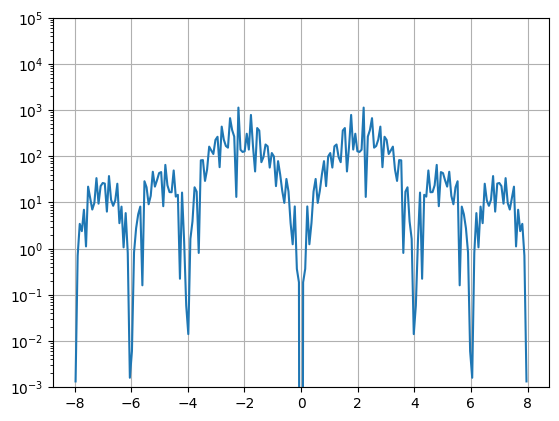

In [310]:
s_hf_spectrum = np.fft.fftshift(np.fft.fft(s_hf))
f = np.fft.fftshift(np.fft.fftfreq(s_hf.size, T_sample))

plt.plot(f, np.abs(s_hf_spectrum)**2)
plt.grid(True)
plt.yscale('log')
plt.ylim(10e-4, 10e4)
plt.show()

## Empfänger

Bei der _Direct Downconversation_ (bild einfügen), wird vom Empfangssignal im SDR der I und Q Teil separat extrahiert. Nur so kann das reale Empfangssignal wieder in die komplexe Basisbandsignalform zurückgeführt werden.

### Quantisierungsfehler fehlt (Zeitliche diskretisierung und Quantisierung der Amplitudenwerte)

![IQ Sampling Receiver](./images/IQ_sampling_receiver.png)
* Extraktion des I-Anteils:
$$
    \hat{I}_{\tiny{\text{No Filter}}}(t) = s_{\text{HF}}(t) \cos(2 \pi f_{\text{c}} t) =  \frac{1}{2} I(t) \text{ } cos (4 \pi f_{\text{c}} t) + \frac{1}{2} \text{ } Q(t) \text{ } I(t)\text{ } sin(4 \pi f_{\text{c}} t) +  \frac{1}{2} \text{ } I(t)
$$
Die hochfrequenten Anteile bei $2f_{\text{c}}$ und $-2f_{\text{c}}$ werden durch einen Tiefpassfilter eliminiert. Das Basisbandsignal $Q[n]$ wird dann durch eine Abtastung des Signals gewonnen.
$$
\hat{I}_{\tiny{\text{LP}}}[n] \approx I[n] \text{, mit } I[n] = \sum_{k=0}^{N-1} I[k] \delta\left(n - kT\right) * h_{\tiny{\text{Pulse Form}}}[n]
$$
$$
h_{\tiny{\text{Pulse Form}}}[n] = \text{sinc}\left(\frac{n}{T_s f_s}\right) \cdot \frac{\cos\left(\pi \beta \frac{n}{T_s f_s}\right)}{1 - \left(2 \beta \frac{n}{T_s f_s}\right)^2}
$$

where:
\begin{align*}
\text{sinc}(x) &= \frac{\sin(\pi x)}{\pi x} \\
T_s &= \text{symbol period} \\
\beta &= \text{roll-off factor} \\
f_s &= \text{sampling frequency}
\end{align*}


* Extraction of the Q component:
$$
    \hat{Q}_{\tiny{\text{No Filter}}}(t) = s_{\text{HF}}(t) \sin(2 \pi f_{\text{c}} t) = \frac{1}{2} \text{ } I(t) \text{ }  Q(t) \text{ } \sin(4 \pi f_{\text{c}} t) - \frac{1}{2} \text{ } Q(t) \text{ } \cos(4 \pi f_{\text{c}} t) +  \frac{1}{2} Q(t)
$$
Die hochfrequenten Anteile bei $2f_{\text{c}}$ und $-2f_{\text{c}}$ werden durch einen Tiefpassfilter eliminiert. Das Basisbandsignal $I[n]$ wird dann durch eine Abtastung des Signals gewonnen.
$$
\hat{Q}_{\tiny{\text{LP}}}[n] \approx Q[n] \text{, mit } Q[n] = \sum_{k=0}^{N-1} Q[k] \delta\left(n - kT\right) * h_{\tiny{\text{Pulse Form}}}[n]
$$
$$
h_{\tiny{\text{Pulse Form}}}[n] = \text{sinc}\left(\frac{n}{T_s f_s}\right) \cdot \frac{\cos\left(\pi \beta \frac{n}{T_s f_s}\right)}{1 - \left(2 \beta \frac{n}{T_s f_s}\right)^2}
$$

where:
\begin{align*}
\text{sinc}(x) &= \frac{\sin(\pi x)}{\pi x} \\
T_s &= \text{symbol period} \\
\beta &= \text{roll-off factor} \\
f_s &= \text{sampling frequency}
\end{align*}

Am Ende werden vom SDR die I und Q Komponenten wieder zu einem komplexen Signal zusammengefügt, dass im NumPy Array dann der Realteil eines Samples dessen I Sample enthält und der Imaginärteil dessen zugehörigen Q Sample enthält.

Ein Sample am Index $n$ eines NumPy Arrays enthält also die I und Q Komponente des $n$-ten Symbols:

$$
    \text{Array}[n] = I[n] + j \text{ } Q[n]
$$

In [311]:
# Receiver
# Downconvert the signal
x_hat_i = s_hf * s_c_I
t = np.arange(x_hat_i.size) * T_sample

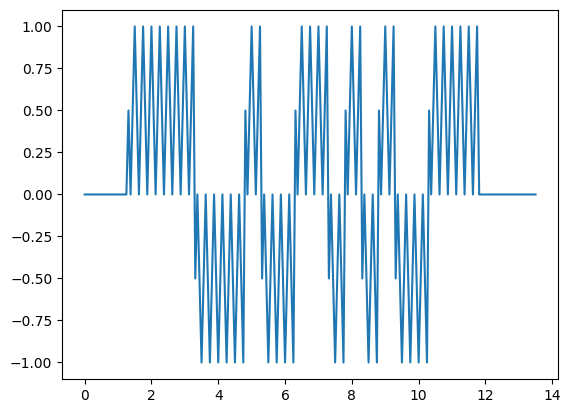

In [312]:
plt.plot(t, x_hat_i)

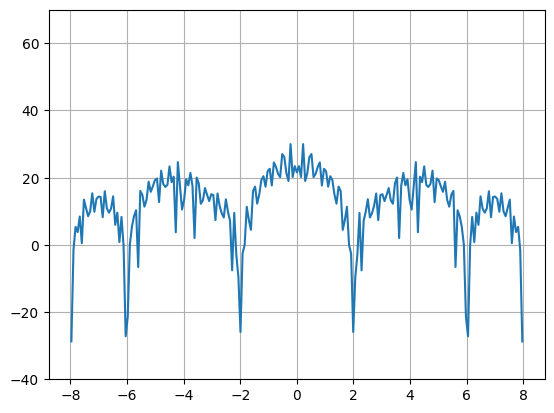

In [313]:
# spectrum of the downconverted signal
f = np.fft.fftshift(np.fft.fftfreq(len(x_hat_i), T_sample))
downconverted_signal_spectrum = np.fft.fftshift(np.fft.fft(x_hat_i))
plt.plot(f, 20*np.log10(np.abs(downconverted_signal_spectrum)))
plt.grid(True)
plt.ylim(-40, 70)
plt.show()

In [ ]:
len(downconverted_signal)

In [314]:
def convert_f_Hz_to_index(f_Hz: float, f: np.ndarray):
    return np.argmin(np.abs(f - f_Hz))

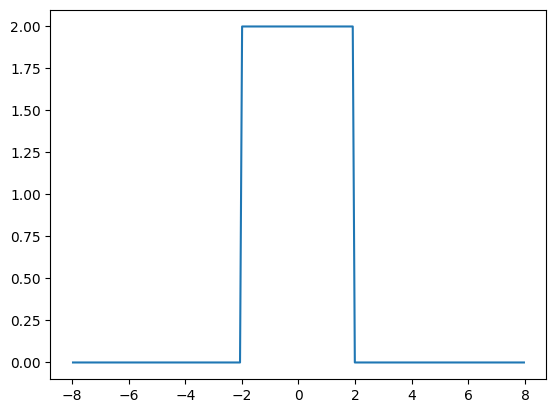

In [315]:
# tiefpassfilter um das basisbandsignal zu erhalten -> eliminiere frequenzen größer +- fc
f = np.fft.fftshift(np.fft.fftfreq(len(x_hat_i), T_sample))

rect = np.zeros(len(f))
# correct the 1/2 factor from downconversion

# TODO: Calculate the Nyquist frequency and set the cutoff frequency to 1/4 of the Nyquist frequency
border = 1/T_s
# index from f at border
left_index = convert_f_Hz_to_index(-border, f)
rigth_index = convert_f_Hz_to_index(border, f)
rect[left_index:rigth_index] = 1
rect = rect * 2
plt.plot(f, rect)


/var/folders/89/fxr0x5lx46z0k6v48n7hxp6c0000gn/T/ipykernel_95588/2547916985.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.plot(f, 20*np.log10(np.abs(downconverted_filtered_spectrum)))


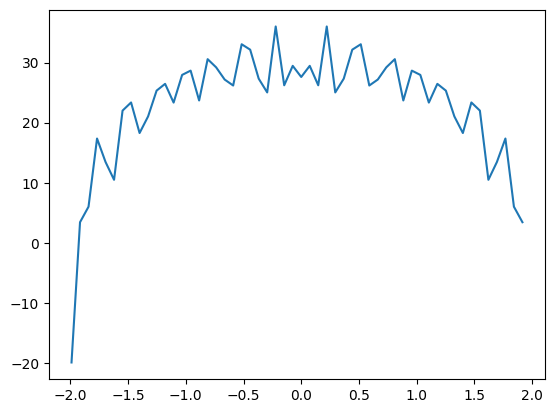

In [317]:
downconverted_filtered_spectrum = downconverted_signal_spectrum * rect
f = np.fft.fftshift(np.fft.fftfreq(downconverted_filtered_spectrum.size, T_sample))
plt.plot(f, 20*np.log10(np.abs(downconverted_filtered_spectrum)))

/opt/homebrew/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


ValueError: x and y must have same first dimension, but have shapes (217,) and (133,)

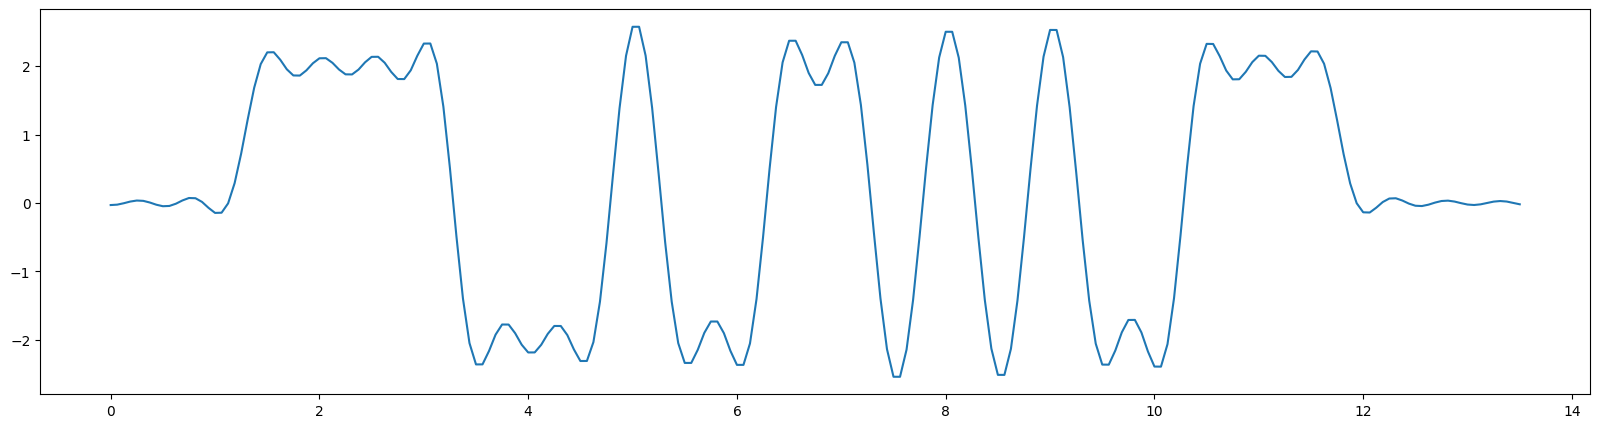

In [318]:
plt.figure(figsize=(20, 5))
plt.plot(t, downconverted_filtered)
plt.plot(t, x_shaped)
plt.grid(True)
plt.legend(['downconverted_filtered', 'x_shaped'])

# Berechnung der Abtastzeitpunkte
sample_times = np.arange(len(downconverted_signal)) /fs + (num_taps // 2) / fs

for sample_time in sample_times:
    # Finden des nächstgelegenen Index in t
    idx = np.argmin(np.abs(t - sample_time))
    plt.vlines(t[idx], 0, downconverted_filtered[idx], color='red')
    plt.plot(t[idx], downconverted_filtered[idx], 'o', color='red')


plt.xlabel('Zeit (s)')
plt.ylabel('Amplitude')
plt.title('Gefilterte und heruntergemischte BPSK-Signale mit Abtastpunkten')
plt.show()



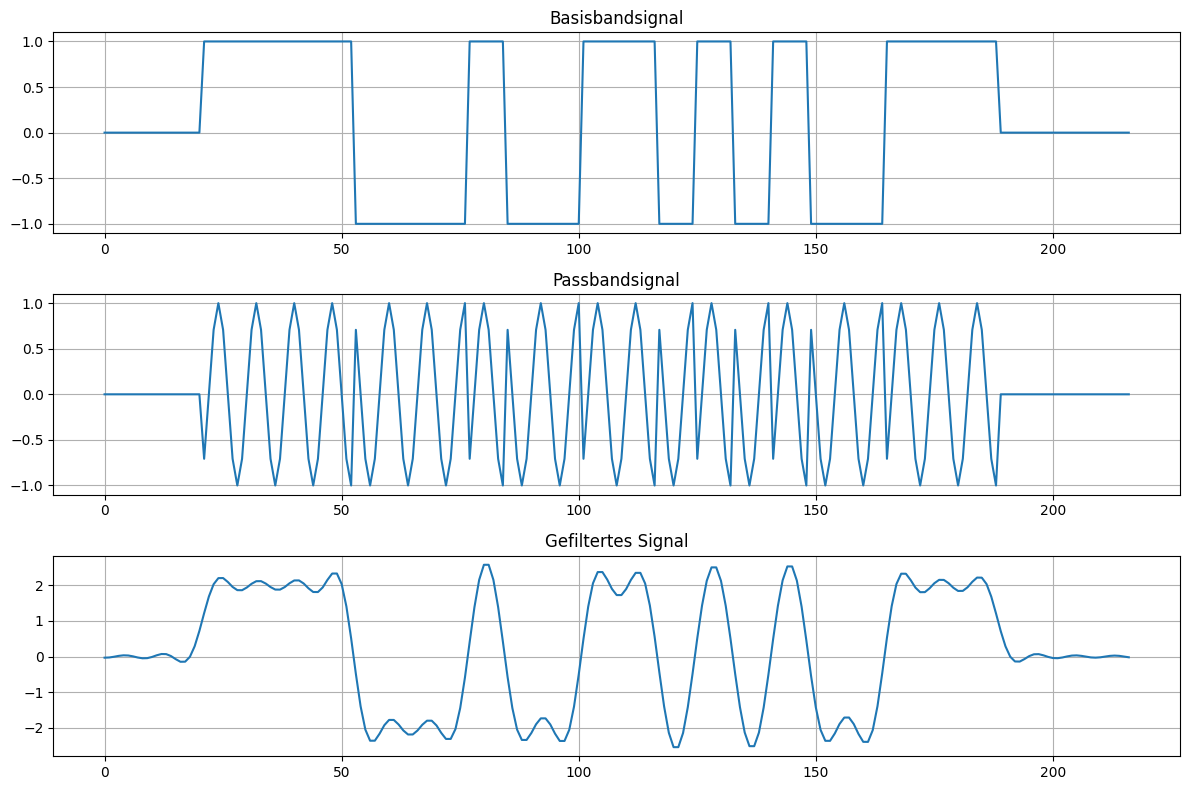

In [320]:
# TODO: Konsistente Farben dafür verwenden 1 Farbe für alles was das SDR macht und eine Farbe die man selbst der API übergibt

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(x_i_shaped)
plt.title("Basisbandsignal")
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(s_hf)
plt.title("Passbandsignal")
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(downconverted_filtered)
plt.title("Gefiltertes Signal")
plt.grid(True)

plt.tight_layout()
plt.show()

# Frage: Woher kommen wenn ein Rechteck als Basisbandpulsform verwendet wird unten nach der Tiefpassfilterung die Überschwinger?
- Ein Rechteck hat eine unendliche Bandbreite
- Bei der Tiefpassfilterung werden die hohen Frequenzen abgeschnitten
- Die Überschwinger kommen also daher, dass die hohen Frequenzen abgeschnitten werden und somit im Zeitbereich Überschwinger entstehen

ValueError: x and y must have same first dimension, but have shapes (217,) and (133,)

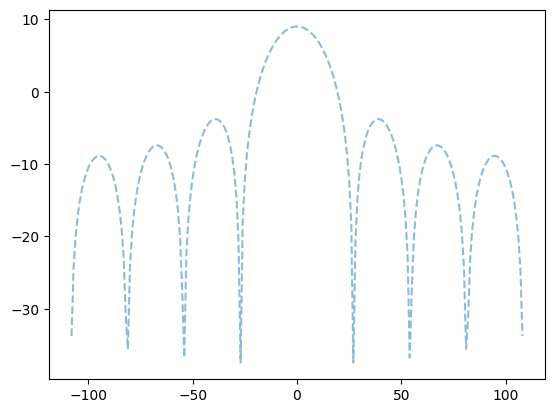

In [321]:
f_bins = np.arange(0, len(downconverted_filtered)) - len(downconverted_filtered)//2

base_band_pulse = get_rect_pulse(num_taps=len(downconverted_filtered))
# norm the signals to 1
norm_factor = 1/np.sqrt(2)
downconverted_filtered_normalized = normalize_energy(downconverted_filtered)
x_shaped_normalized               = normalize_energy(x_shaped)
baseband_signal_normalized        = normalize_energy(base_band_pulse)

# TODO: Alle Signale in der leistung auf 1 normieren damit hier alle übereinander liegen
# Hier anpassen, je nachdem welcher Basisbandpuls verwendet wird (Rechteck oder Raised Cosine)
plt.plot(f_bins, 20*np.log10(np.abs(np.fft.fftshift(np.abs(np.fft.fft(baseband_signal_normalized))))), alpha=0.5, linestyle='--')
plt.plot(f_bins, 20*np.log10(np.abs(np.fft.fftshift(np.abs(np.fft.fft(x_shaped_normalized       ))))), alpha=0.5, linestyle='-')
plt.plot(f_bins, 20*np.log10(np.abs(np.fft.fftshift(np.abs(np.fft.fft(downconverted_filtered_normalized))))), color='black', linewidth=3, alpha=0.75)

plt.legend(["Basisband Puls", "Basisbandsignal", "Gefiltertes Signal"])
plt.grid(True)
plt.ylim(-50,20)

# Am ende den SDR Teil überspringen
# SDR Box mit farben verwenden die wieder zeigt was das sdr macht und was das eigene Signal ist

# Nächstes Notebook: SIGMF Reader Vorbereiten, notebook vorbereiten, wie bursts übertragen werden
Ziel SiGMF FIles erzeugen, einlesen

1. Sigmf Schreiben (Burst Dauer, CFO, Fc etc einstellen)
2. Sigmf lesen und auf API Schnittstelle zum sendn bringen
3. Ziel für Praxisphase: man kann sigmf files breitstellen
4. Dann Synchronisation

In [335]:
fs = sps

# Das ist nun der I Teil des empfangenen Signals
rx_sampled = downconverted_filtered[::fs].real

# Das SDR liefert nun daraus ein NumpPy Array mit dem dtype complex64
rx_sampled = rx_sampled.astype(np.complex64)


In [336]:
print(rx_sampled)

[-0.03029574+0.j -0.04734427+0.j -0.14517394+0.j  2.202981  +0.j
  2.1165247 +0.j  2.1372926 +0.j  2.331573  +0.j -2.3614457 +0.j
 -2.1864946 +0.j -2.3114054 +0.j  2.5770857 +0.j -2.3397074 +0.j
 -2.368173  +0.j  2.3730187 +0.j  2.3507748 +0.j -2.5419102 +0.j
  2.5043614 +0.j -2.5141401 +0.j  2.5311782 +0.j -2.3640332 +0.j
 -2.3927042 +0.j  2.3273158 +0.j  2.1542249 +0.j  2.21815   +0.j
 -0.13633755+0.j -0.04034569+0.j -0.02291566+0.j -0.01933253+0.j]


# Ende des Notebooks, Nachfolgender Teil kommt in die Synchronisation

In [337]:
rx_sampled


array([-0.03029574+0.j, -0.04734427+0.j, -0.14517394+0.j,  2.202981  +0.j,
        2.1165247 +0.j,  2.1372926 +0.j,  2.331573  +0.j, -2.3614457 +0.j,
       -2.1864946 +0.j, -2.3114054 +0.j,  2.5770857 +0.j, -2.3397074 +0.j,
       -2.368173  +0.j,  2.3730187 +0.j,  2.3507748 +0.j, -2.5419102 +0.j,
        2.5043614 +0.j, -2.5141401 +0.j,  2.5311782 +0.j, -2.3640332 +0.j,
       -2.3927042 +0.j,  2.3273158 +0.j,  2.1542249 +0.j,  2.21815   +0.j,
       -0.13633755+0.j, -0.04034569+0.j, -0.02291566+0.j, -0.01933253+0.j],
      dtype=complex64)

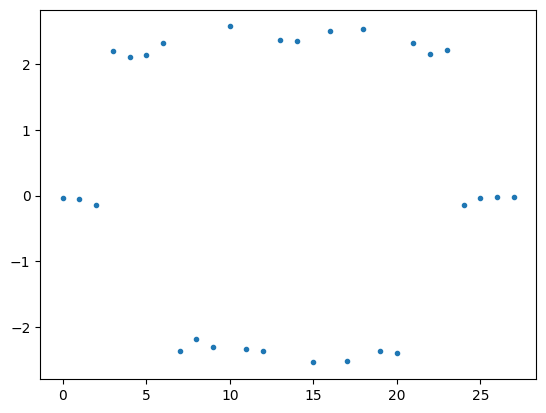

In [338]:
plt.plot(rx_sampled, '.')

/var/folders/89/fxr0x5lx46z0k6v48n7hxp6c0000gn/T/ipykernel_95588/4165057121.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  corr[i] = np.dot(rx_sampled[i:i+len(synchronization_sequence)], synchronization_sequence)


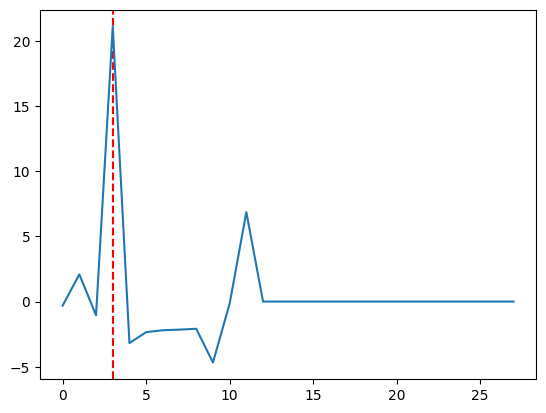

In [339]:
corr = np.zeros(len(rx_sampled))

for i in range(len(rx_sampled) - len(synchronization_sequence)):
    corr[i] = np.dot(rx_sampled[i:i+len(synchronization_sequence)], synchronization_sequence)

tau0 = np.argmax(np.abs(corr))
plt.axvline(tau0, color='r', linestyle='--')
plt.plot(corr)

In [340]:
print(f"tau0: {tau0}")
print(f"rx len: {len(rx_sampled)}")


tau0: 3
rx len: 28


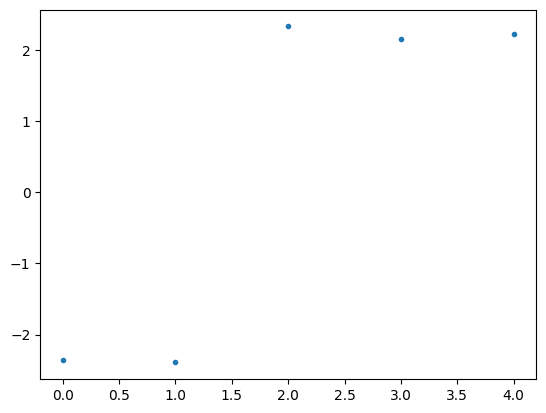

In [341]:
# data bits start at tau0 + len(syncronisation_sequence) and end at tau0 + len(syncronisation_sequence) + len(data_bits)
data_symbols_received = rx_sampled[tau0+len(synchronization_sequence):tau0 + len(synchronization_sequence) + len(data_bits)]
plt.plot(data_symbols_received, '.')

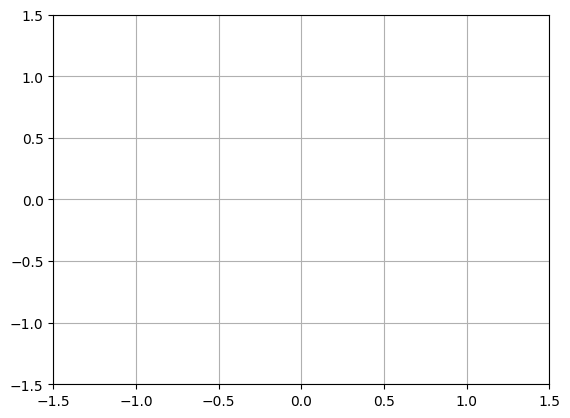

In [342]:
# iq plot
plt.scatter(np.real(data_symbols_received), np.imag(data_symbols_received), alpha=0.5, color='red')
plt.ylim(-1.5, 1.5)
plt.xlim(-1.5, 1.5)
plt.grid(True)


In [343]:
# decision making
data_bits_received = np.zeros_like(data_bits)
for i, symbol in enumerate(data_symbols_received):
    if symbol.real > 0:
        data_bits_received[i] = 1
    else:
        data_bits_received[i] = 0

print("bits^hat = ", data_bits_received)
print("bits     = ", data_bits)

bits^hat =  [0 0 1 1 1]
bits     =  [0 0 1 1 1]
